In [18]:
import math

In [19]:
# Defining the Node Class that stores a value

class Node:
    nameLetterVal = 65  # Stores ASCII Value of name for new Node
    def __init__(self, data = 0.0, name = None, _children = (), _op = None):
        name = chr(Node.nameLetterVal)
        Node.nameLetterVal += 1                 # Update Name
        self.name = name
        self.data = data
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
    
    def __repr__(self):
        return f"{self.name} : (Value = {self.data})"
    
    def __add__(self, other):
        outputData = self.data + other.data
        outputNode = Node(outputData, _children = (self, other), _op = "+")
        def _backward():
            self.grad += 1.0 * outputNode.grad
            other.grad += 1.0 * outputNode.grad
        outputNode._backward = _backward
        return outputNode
    
    def __mul__(self, other):
        outputData = self.data * other.data
        outputNode = Node(outputData, _children = (self, other), _op = "*")
        def _backward():
            self.grad += float(other.data) * outputNode.grad
            other.grad += float(self.data) * outputNode.grad
        outputNode._backward = _backward
        return outputNode
    
    def __rmul__(self, other):
        return self * other
    
    
    def tanh(self):
        outputData = (math.exp(2*self.data) - 1.0) / (math.exp(2*self.data) + 1.0)
        outputNode = Node(outputData, _children = (self, ), _op = "tanh")
        def _backward():
            self.grad += (1 - (outputData**2)) * outputNode.grad
        outputNode._backward = _backward
        return outputNode

    def backward(self):
        # Topological sort (To ensure we are backpropagating in the correct order)
        topo = []
        visited = set()
        def build_topological_graph(node):
            if (node not in visited):
                visited.add(node)
            for child in node._prev:
                build_topological_graph(child)
            topo.append(node)
        build_topological_graph(self)
        topo = topo[::-1]
        for node in topo:
            node._backward()

a = Node(3.0)
b = Node(-3.0)
c = a * b
d = Node(10.0)
e  = c  + d

In [20]:
e._op

'+'

In [21]:

# Visualize the connections
from graphviz import Digraph as dir_graph

def trace(result):
    # Use DFS to build a set of all nodes and edges starting from the final result node
    nodes = set()
    edges = set()
    def build(node):
        if (node not in nodes):
            nodes.add(node)
            for child in (node._prev):
                edges.add((child, node))
                build(child)
    build(result)
    return (nodes, edges)

def draw_graph(result):
    graph = dir_graph(format = 'svg', graph_attr = {'rankdir': "LR"})  # Draw the graph from left to right
    nodes, edges = trace(result)
    for node in nodes:
        # For every node, create a rectangle
        graph.node(name = node.name, label = "{%s | data: %.3f | gradient: %.3f}" % (node.name, node.data, node.grad), shape = "record")

        # For non-input nodes, create an operation node behind it
        if node._op:
            opNodeName = node.name + node._op
            graph.node(name = opNodeName, label = node._op)
            graph.edge(opNodeName, node.name)
    
    for node1, node2 in edges:
        graph.edge(node1.name, node2.name + node2._op)
    
    return graph

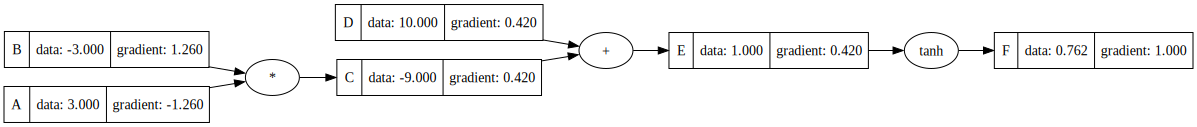

In [22]:
f = e.tanh()
f.grad = 1.0
f.backward()
draw_graph(f)